In [1]:
import numpy as np
import bias_emulator
import hmf_emulator
import aemulus_data as AD
import aemulus_extras as ae
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
%matplotlib inline

In [2]:
plt.rc("font", size=16, family="serif")
plt.rc("errorbar", capsize=3)
#plt.rc("text", usetex=True)

In [3]:
redshifts = 1./AD.scale_factors() - 1
HRredshifts = 1./AD.highres_scale_factors() - 1
colors = [plt.get_cmap("seismic")(ci) for ci in np.linspace(1.0, 0.0, len(redshifts))]
HRcolors = [plt.get_cmap("seismic")(ci) for ci in np.linspace(1.0, 0.0, len(HRredshifts))]

In [28]:
def get_MB_emulators(box):
    cosmo_index = box
    #Note: we remove sigma8 from the list of parameters
    cosmology = AD.test_box_cosmologies()[cosmo_index][:-1]
    cosmo_dict = {"omega_b":cosmology[0], "omega_cdm":cosmology[1], "w0":cosmology[2],
                 "n_s":cosmology[3], "ln10As":cosmology[4],"H0":cosmology[5], "N_eff":cosmology[6]}
    print("Cosmology for medbox %d loaded"%cosmo_index)
    print cosmo_dict
    Extras = ae.Extras(cosmo_index, testing=True)
    
    bias_emu = bias_emulator.bias_emulator()
    bias_emu.set_cosmology(cosmo_dict)
    hmf_emu = hmf_emulator.hmf_emulator()
    hmf_emu.set_cosmology(cosmo_dict)
    return Extras, bias_emu, hmf_emu

def get_HR_emulators(box):
    cosmo_index = 11
    #Note: we remove sigma8 from the list of parameters
    cosmology = AD.highres_box_cosmologies()[cosmo_index]
    cosmo_dict = {"omega_b":cosmology[0], "omega_cdm":cosmology[1], "w0":cosmology[2],
                 "n_s":cosmology[3], "ln10As":cosmology[4],"H0":cosmology[5], "N_eff":cosmology[6]}
    print("Cosmology for medbox %d loaded"%cosmo_index)
    Extras = ae.Extras(cosmo_index, highres=True)
    
    bias_emu = bias_emulator.bias_emulator()
    bias_emu.set_cosmology(cosmo_dict)
    hmf_emu = hmf_emulator.hmf_emulator()
    hmf_emu.set_cosmology(cosmo_dict)
    return Extras, bias_emu, hmf_emu

In [5]:
def get_HR_data(snap):
    dp = "/Users/tmcclintock/Data/highres_linear_bias/"
    inpath = dp+"HRBox011_Z%d_DS50_linearbias.txt"%snap
    M,Mlo,Mhi,b,be = np.loadtxt(inpath, unpack=True)
    Mhi[-1] = 10**16.5
    return M, Mlo, Mhi, b, be

def get_MB_data(box, snap):
    dp = "/Users/tmcclintock/Data/medbox_linear_bias/MedBox%03d_bias/"%box
    inpath = dp+"MedBox%03d_Z%d_DS50_linearbias.txt"%(box, snap)
    M,Mlo,Mhi,b,be = np.loadtxt(inpath, unpack=True)
    Mhi[-1] = 10**16.5
    return M, Mlo, Mhi, b, be

def get_MBauto_data(box, snap):
    dp = "/Users/tmcclintock/Data/aemulus_hhbias/medbox/"
    inpath = dp+"MedBox%03d_Z%d_DS50_auto_linearbias.txt"%(box, snap)
    M,Mlo,Mhi,b,be = np.loadtxt(inpath, unpack=True)
    Mhi[-1] = 10**16.5
    b = np.sqrt(b)
    be = be/(2*b)
    return M, Mlo, Mhi, b, be

In [6]:
def bin_ave_biases_in_snap(redshift, Mlos, Mhis, bias_emu, hmf_emu):
    Marr = np.logspace(np.log10(Mlos[0]), np.log10(Mhis[-1]), 1000)
    lnMarr = np.log(Marr)
    bias_at_Marr = bias_emu.bias(Marr, redshift)
    dndM_at_Marr = hmf_emu.dndM(Marr, redshift)
    
    bhmf_spl = IUS(lnMarr, bias_at_Marr*dndM_at_Marr*Marr)
    hmf_spl = IUS(lnMarr, dndM_at_Marr*Marr)

    lnMlos = np.log(Mlos)
    lnMhis = np.log(Mhis)
    
    output = np.zeros_like(Mlos)
    for i in range(len(output)):
        num = bhmf_spl.integral(lnMlos[i], lnMhis[i])
        den = hmf_spl.integral(lnMlos[i], lnMhis[i])
        output[i] = num/den
    return output

In [32]:
#A function to add the HR data
def addHR_to_axes(axhi, axlo):
    Ms, _, bs, bes, bemus, pds, pd_es, boxes, snaps = np.loadtxt("data_for_plots/highres_resids.txt").T
    #_, bias_emu, hmf_emu = get_HR_emulators(11)
    for snap in [1, 3, 13]:#[2, 6, 9]:
        inds = (snaps==snap)*(boxes==11)
        #M, Mlo, Mhi, b, be = get_HR_data(snap)
        #bm = bin_ave_biases_in_snap(HRredshifts[snap], Mlo, Mhi, bias_emu, hmf_emu)
        M = Ms[inds]
        b = bs[inds]
        be = bes[inds]
        bm = bemus[inds]
        
        axhi.errorbar(M, b, be, c=HRcolors[snap], ls='', marker='.', 
                      markersize=3, label=r"400 $h^{-1}{\rm Mpc}$ at $z=%.1f$"%(HRredshifts[snap]))
        axhi.plot(M, bm, c=HRcolors[snap])
        axlo.errorbar(M, 100*(b-bm)/bm, 100*be/bm, c=HRcolors[snap], ls='', marker='.', markersize=3)
    axhi.legend(loc="upper left", frameon=False, fontsize=12)
    axlo.axhline(0, c='k', ls='--')
    return

def addMB_to_axes(axhi, axlo):
    _, bias_emu, hmf_emu = get_MB_emulators(0)
    for snap in [1, 2, 5, 7, 9]:
        M, Mlo, Mhi, b, be = get_MB_data(0, snap)
        if snap == 1:
            print M, b
        _, _, _, b2, be2 = get_MBauto_data(0, snap) #from hh

        bm = bin_ave_biases_in_snap(redshifts[snap], Mlo, Mhi, bias_emu, hmf_emu)
        
        axhi.errorbar(M, b, be, c=colors[snap], ls='', marker='.', markersize=3, 
                      label=r"3 $h^{-1}{\rm Gpc}$ at $z=%.1f$"%(redshifts[snap]))
        #axhi.errorbar(M, b2, be2, c=colors[snap], ls='', marker='^', markersize=6)
        axhi.plot(M, bm, c=colors[snap])
        axlo.errorbar(M, 100*(b-bm)/bm, 100*be/bm, c=colors[snap], ls='', marker='.', markersize=3)
        #axlo.errorbar(M, 100*(b2-bm)/bm, 100*be2/bm, c=colors[snap], ls='', marker='^', markersize=6)
    axhi.legend(loc="upper left", frameon=False, fontsize=12)
    axlo.axhline(0, c='k', ls='--')
    return

Cosmology for medbox 0 loaded
{'N_eff': 2.95, 'H0': 63.2317, 'w0': -0.726513, 'n_s': 0.980515, 'ln10As': 3.03895, 'omega_b': 0.0232629, 'omega_cdm': 0.10783}
('Medbox params:', array([ 1.24635302, -1.34371134,  0.97636315,  1.06496136]))
[5.8561280e+13 6.9207648e+13 1.0447971e+14] [ 9.25347638  9.91651946 11.58428633]


/Users/tmcclintock/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


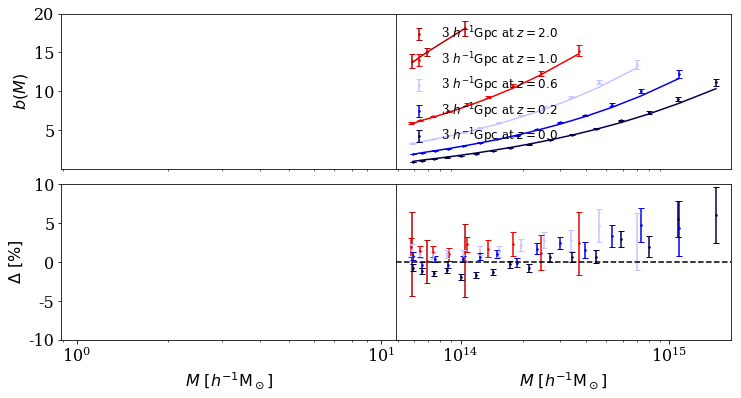

In [33]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,6))
plt.subplots_adjust(hspace=0.1, wspace=0)
for i in [0,1]:
    for j in [0,1]:
        ax[i][j].set_xscale('log')
        ax[i][j].set_yticks([])
        ax[i][j].set_yticklabels([])
ax[0][0].set_ylabel(r"$b(M)$")
ax[1][0].set_ylabel(r"$\Delta\ [\%]$")
ax[1][0].set_xlabel(r"$M\ [h^{-1}{\rm M_\odot}]$")
ax[1][1].set_xlabel(r"$M\ [h^{-1}{\rm M_\odot}]$")
ax[0][0].set_ylim(0,20)
ax[1][0].set_ylim(-10, 10)
ax[1][1].set_ylim(-10, 10)

ax[0][0].set_yticks([5,10,15,20])
ax[0][0].set_xticks([])
ax[0][0].set_xticklabels([])
ax[0][1].set_xticks([])
ax[0][1].set_xticklabels([])

ax[0][0].set_yticklabels([5,10,15,20])
ax[1][0].set_yticks([-10, -5, 0, 5, 10])
ax[1][0].set_yticklabels([-10, -5, 0, 5, 10])

addMB_to_axes(ax[0][1], ax[1][1])
#addHR_to_axes(ax[0][0], ax[1][0])
